In [69]:
import matplotlib
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import fastprop
import os
from rdkit import Chem
from fastprop.data import (
    clean_dataset,
    fastpropDataLoader,
    fastpropDataset,
    split,
    standard_scale,
)
from fastprop.defaults import DESCRIPTOR_SET_LOOKUP, _init_loggers, init_logger
from fastprop.descriptors import get_descriptors
from fastprop.io import load_saved_descriptors, read_input_csv
from fastprop.model import fastprop, train_and_test

matplotlib.rcParams.update({'font.style': 'normal'})
matplotlib.rcParams.update({'font.sans-serif': 'Segoe UI'})
matplotlib.rcParams.update({'font.size': 26})

Vermeire Dataset

In [70]:
_src_dir: str = os.path.join(r"C:\Users\ChemeGrad2021\Dropbox (MIT)\Graduate\Third Year\6.C51\SolProp_v1.2", "Data")
room_T_data: pd.DataFrame = pd.read_csv(os.path.join(_src_dir, "CombiSolu-Exp-HighT.csv"))
high_T_data: pd.DataFrame = pd.read_csv(os.path.join(_src_dir, "CombiSolu-Exp.csv"))
all_data: pd.DataFrame = pd.concat((room_T_data, high_T_data))
# drop those missing the solubility
all_data: pd.DataFrame = all_data[all_data['experimental_logS [mol/L]'].notna()]
# drop not-very-soluble species (must be at least 1 mol/L)
#all_data: pd.DataFrame = all_data[all_data['experimental_logS [mol/L]'] > 0]

# find all the unique molecules in the dataset and calculate their descriptors
unique_smiles: np.ndarray = np.hstack((pd.unique(all_data["solvent_smiles"]), pd.unique(all_data["solute_smiles"])))

In [87]:
len(all_data)

6236

([<matplotlib.axis.YTick at 0x23d10076bb0>,
 [Text(0, 0, '0'),
  Text(0, 400, '400'),
  Text(0, 800, '800'),
  Text(0, 1200, '1200')])

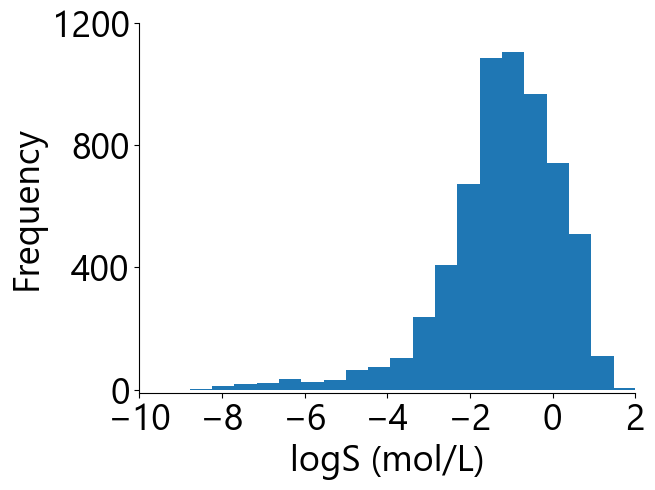

In [71]:
all_data['experimental_logS [mol/L]'].plot(kind='hist', bins=20)
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.xlabel("logS (mol/L)")
plt.xlim([-10, 2])
plt.xticks([-10, -8, -6, -4, -2, 0, 2 ])
plt.ylim([-10, 1200])
plt.yticks([0, 400, 800, 1200])

In [90]:
all_data['experimental_logS [mol/L]'].max()

2.01435

(-10.0, 1000.0)

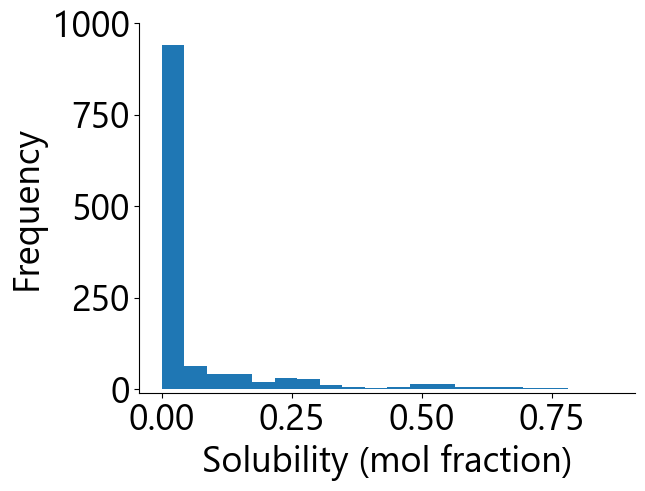

In [72]:
all_data['mol_fraction_solubility'].plot(kind='hist', bins=20)
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.xlabel("Solubility (mol fraction)")
plt.ylim([-10, 1000])

In [55]:
unique_solvents = pd.unique(all_data["solvent_smiles"])
unique_solutes = pd.unique(all_data["solute_smiles"])
print(len(unique_solvents), len(unique_solutes))

rdkit_mols_solvent = np.array(list(Chem.MolFromSmiles(i) for i in unique_solvents))
rdkit_mols_solute = np.array(list(Chem.MolFromSmiles(i) for i in unique_solutes))


cache_filepath = "solvent_descriptors.csv"
solvent_descriptors = get_descriptors(cache_filepath, DESCRIPTOR_SET_LOOKUP["all"], rdkit_mols_solvent)
solvent_descriptors = solvent_descriptors.to_numpy(dtype=float)

cache_filepath = "solute_descriptors.csv"
solute_descriptors = get_descriptors(cache_filepath, DESCRIPTOR_SET_LOOKUP["all"], rdkit_mols_solute)
solute_descriptors = solute_descriptors.to_numpy(dtype=float)

99 165


100%|██████████| 165/165 [00:13<00:00, 12.01it/s]


Boobier Dataset

In [95]:
_src_dir: str = os.path.join(r"C:\Users\ChemeGrad2021\Documents", "highsol")
benzene_data: pd.DataFrame = pd.read_csv(os.path.join(_src_dir, "benzene_solubility_data_features.csv"))
acetone_data: pd.DataFrame = pd.read_csv(os.path.join(_src_dir, "acetone_solubility_data_features.csv"))
ethanol_data: pd.DataFrame = pd.read_csv(os.path.join(_src_dir, "ethanol_solubility_data_features.csv"))

# find all the unique molecules in the dataset and calculate their descriptors
print(len(pd.unique(benzene_data["solute_smiles"])))
print(len(pd.unique(acetone_data["solute_smiles"])))
print(len(pd.unique(ethanol_data["solute_smiles"])))

all_solutes = pd.concat([benzene_data, acetone_data, ethanol_data], axis = 0)
unique_solutes = pd.unique(all_solutes["solute_smiles"])
print(len(unique_solutes))

425
405
639
1440


([<matplotlib.axis.YTick at 0x23d176821f0>,
 [Text(0, 0, '0'), Text(0, 25, '25'), Text(0, 50, '50'), Text(0, 75, '75')])

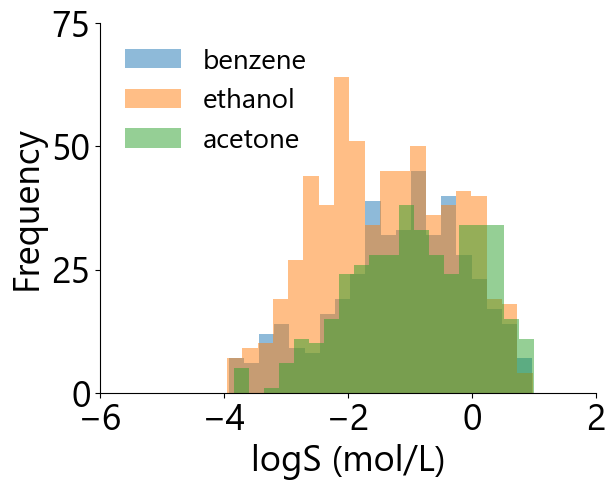

In [111]:
benzene_data['logS'].plot(kind='hist', bins=20, alpha = 0.5, label = 'benzene')
ethanol_data['logS'].plot(kind='hist', bins=20, alpha = 0.5, label = 'ethanol')
acetone_data['logS'].plot(kind='hist', bins=20, alpha = 0.5, label = 'acetone')
plt.legend(prop={'size': 20}, frameon = False)
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.xlabel("logS (mol/L)")
plt.xlim([-6, 2])
plt.xticks([ -6, -4, -2, 0, 2 ])
plt.ylim([0, 75])
plt.yticks([0, 25, 50, 75])

Exploring Model Performance